In [ ]:
# Install transformers and thai2transformers
!pip install transformers
!pip install -q emoji pythainlp==2.2.4 sefr_cut tinydb seqeval sentencepiece pydantic jsonlines
!pip install --no-deps thai2transformers==0.1.2
!pip install evaluate

In [ ]:
!pip install kaggle

# Authenticate Kaggle API
import os
os.environ['KAGGLE_USERNAME'] = 'nink5536'
os.environ['KAGGLE_KEY'] = 'bc5abe933a7268e641f87c603cf90249'

# Download kernel output
!kaggle kernels output ninktest/xlm-roberta-base -p /kaggle/working/

In [19]:
import shutil
import os

# Define source and destination directories
source_directory = '/kaggle/working/results/checkpoint-11250'
destination_directory = '/kaggle/working/results'

# Move all files from the source directory to the destination directory
for file_name in os.listdir(source_directory):
    full_file_name = os.path.join(source_directory, file_name)
    if os.path.isfile(full_file_name):
        shutil.move(full_file_name, destination_directory)

# Remove the now empty source directory
shutil.rmtree(source_directory)

# Print the remaining files to verify
print("Files in the results directory:")
print(os.listdir(destination_directory))


Files in the results directory:
['model.safetensors', 'trainer_state.json', 'scheduler.pt', 'tokenizer_config.json', 'sentencepiece.bpe.model', 'rng_state.pth', 'optimizer.pt', 'special_tokens_map.json', 'config.json', 'training_args.bin']


In [6]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from datasets import load_dataset, load_metric
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, load_metric
import matplotlib.pyplot as plt
import evaluate

In [7]:
# Load tokenizer and model
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
import pandas as pd
df = pd.read_csv('/kaggle/input/tickettype/data.csv')
df.drop(columns=['Unnamed: 0'])
df['text'] = df['clean_subject'] + ' ' + df['clean_description']

In [10]:
data = df[['ticket_type','text']]
data = data[data['ticket_type'] != 'Problem'] #Drop Class Problem
data.dropna(subset=['text'], inplace=True)

In [12]:
tokenizer

XLMRobertaTokenizer(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	250001: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [13]:
model

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

In [14]:
# Encode labels as integers
label2id = {'Incident': 0, 'Request': 1}
data['labels'] = data['ticket_type'].map(label2id)

In [15]:
# Sample 50,000 from each class
df_request = data[data['ticket_type'] == 'Request'].sample(n=50000, random_state=42)
df_incident = data[data['ticket_type'] == 'Incident'].sample(n=50000, random_state=42)
df_balanced = pd.concat([df_request, df_incident]).reset_index(drop=True)

In [16]:
# Split the data into train+val and test sets
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df_balanced['text'].tolist(), df_balanced['labels'].tolist(), test_size=0.2, random_state=42)

# Further split train+val into train and val sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels, test_size=0.25, random_state=42)


In [17]:
print(df_balanced['ticket_type'].value_counts())

ticket_type
Request     50000
Incident    50000
Name: count, dtype: int64


In [18]:
# Tokenize data
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels})
val_dataset = Dataset.from_dict({'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask'], 'labels': val_labels})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'labels': test_labels})

In [20]:
from transformers import TrainingArguments, EarlyStoppingCallback
import os
os.environ["WANDB_DISABLED"] = "true"

# Define training arguments without WandB
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=1000,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [21]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import evaluate

# Load metric
accuracy_metric = evaluate.load("accuracy")

# Custom callback for collecting loss and accuracy
class CustomCallback(TrainerCallback):
    def __init__(self):
        self.losses = []
        self.accuracies = []

    def on_epoch_end(self, args, state, control, **kwargs):
        output = trainer.evaluate(eval_dataset=val_dataset)
        self.losses.append(output["eval_loss"])
        self.accuracies.append(output["eval_accuracy"])

# Initialize the callback
callback = CustomCallback()

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {"accuracy": accuracy_metric.compute(predictions=p.predictions.argmax(-1), references=p.label_ids)["accuracy"]},
    callbacks=[callback, EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
# Train the model 03e121b5249ddc41bae22e9ba18fbb65bed41b1e
trainer.train()

## I have trained it in latest version so I will dummy plot instead
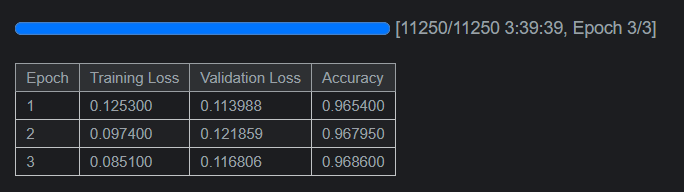

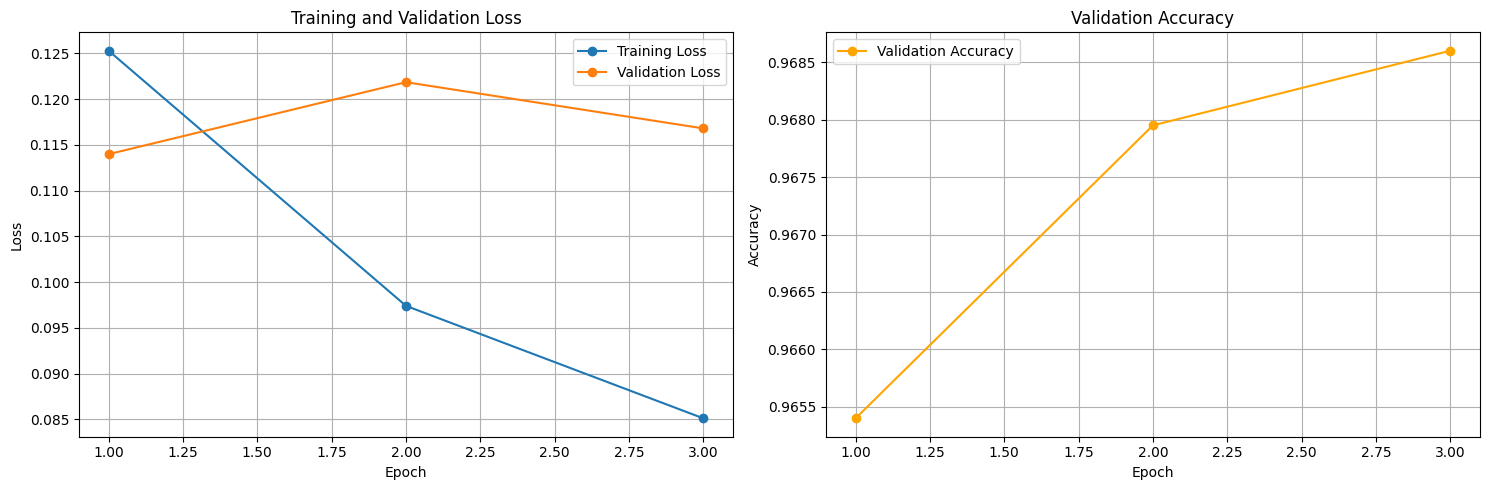

In [28]:
import matplotlib.pyplot as plt

# Dummy data for losses and accuracies
epochs = [1, 2, 3]
train_losses = [0.125300, 0.097400, 0.085100]
val_losses = [0.113988, 0.121859, 0.116806]
val_accuracies = [0.965400, 0.967950, 0.968600]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the loss on the left subplot
axs[0].plot(epochs, train_losses, label='Training Loss', marker='o')
axs[0].plot(epochs, val_losses, label='Validation Loss', marker='o')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].legend()
axs[0].grid(True)

# Plot the accuracy on the right subplot
axs[1].plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Validation Accuracy')
axs[1].legend()
axs[1].grid(True)

# Show the plot
plt.tight_layout()
plt.show()


## load model from output and predict test dataset

In [22]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
import torch

# Load tokenizer and model from the saved files
model_dir = '/kaggle/working/results'
tokenizer = XLMRobertaTokenizer.from_pretrained(model_dir)
model = XLMRobertaForSequenceClassification.from_pretrained(model_dir)

In [24]:
# Check class balance in test_dataset
test_labels = test_dataset['labels']  # Adjust this if your dataset structure is different
class_balance = pd.Series(test_labels).value_counts()
print("Class Balance in Test Dataset:")
print(class_balance)

Class Balance in Test Dataset:
1    10035
0     9965
Name: count, dtype: int64


In [23]:
from sklearn.metrics import accuracy_score
import numpy as np

# Initialize the trainer with the loaded model
training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=16,
    do_train=False,  # We are not training, just evaluating
    do_eval=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

# Predict the test dataset
predictions = trainer.predict(test_dataset)

# Convert predictions to labels
pred_labels = np.argmax(predictions.predictions, axis=-1)

# Calculate accuracy
accuracy = accuracy_score(test_labels, pred_labels)
print(f"Test Accuracy: {accuracy}")

# # Optional: Save predictions to a CSV file
# output_df = pd.DataFrame({'text': test_texts, 'true_label': test_labels, 'pred_label': pred_labels})
# output_df.to_csv('/kaggle/working/test_predictions.csv', index=False)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Test Accuracy: 0.9668


In [26]:
from sklearn.metrics import classification_report

# Generate classification report
target_names = ['Incident', 'Request']
report = classification_report(test_labels, pred_labels, target_names=target_names)
print(report)

# Optional: Save predictions and report to a file
output_df = pd.DataFrame({'text': test_texts, 'true_label': test_labels, 'pred_label': pred_labels})
output_df.to_csv('/kaggle/working/test_predictions.csv', index=False)

with open('/kaggle/working/classification_report.txt', 'w') as f:
    f.write(report)

              precision    recall  f1-score   support

    Incident       0.96      0.98      0.97      9965
     Request       0.98      0.96      0.97     10035

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



In [ ]:
# # Save the model in safetensors format
# model.save_pretrained('/kaggle/working/xlm-roberta-trained/model', safe_serialization=True)
# # Save the tokenizer (tokenizer save_pretrained doesn't change)
# tokenizer.save_pretrained('/kaggle/working/xlm-roberta-trained/token')

# test 10000 rows

In [37]:
# Load the test dataset
test_df = pd.read_csv('/kaggle/input/testdataframe/dataframe_test.csv', encoding='utf-8')

# Display the first few rows
test_df.head()

,ticket_no,subject,description,ticket_type
0,221014120,TREND VG3[Presale] : [ลูกค้าไทยรัฐ] รบกวนเพิ่ม...,From: Nuttapol Nuntawinit <nuttapol.nu@inet.co...,Request
1,230819130,MS-Cloud : Noc ได้รับ Alert : Computer object...,\n\n​​​----- Original Message -----\n​​​​From:...,Incident
2,230722137,Suzuyo : NOC Monitor พบPROBLEM\t -_INEXT-NW_Br...,PROBLEM\t\t-_INEXT-NW_BranchVRF_19913_Suzuyo _...,Incident
3,240529217,Lomphraya [Sale] : ลูกค้าไม่สามารถรีโมทเครื่อง...,From: Poom Musigashat <poom.mu@inet.co.th>\nTo...,Incident
4,24021918,Thai Health Promotion Foundatio : NOC ได้รับ A...,"From: ""Cloud Monitor"" <Cloudcomputing-Monitor@...",Incident


In [39]:
import pandas as pd
import re
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report
import numpy as np

# Load the test dataset
test_df = pd.read_csv('/kaggle/input/testdataframe/dataframe_test.csv', encoding='utf-8')

# Function to extract email subject
def extract_email_subject(text):
    if not isinstance(text, str):
        return ""
    pattern = r"[:\]]\s*(.*)"
    match = re.search(pattern, text)
    return match.group(1).strip() if match else text

# Function to extract email body
def extract_email_body(text):
    if not isinstance(text, str):
        return ""
    body_end_pattern = r"(?i)(\b(best regards|thanks|sincerely|see you soon|regards)\b)"
    match = re.search(body_end_pattern, text)
    if match:
        text = text[:match.start()].strip()
    return text.strip()

# Function to clean text
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|http|<[^>]*>|\S+@\S+|\n+", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.lower().strip()

# Preprocess the test dataset
test_df['clean_subject'] = test_df['subject'].apply(extract_email_subject)
test_df['description'] = test_df['description'].apply(extract_email_body)
test_df['text'] = test_df['clean_subject'] + " " + test_df['description']
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

# Load tokenizer and model from the saved files
model_dir = '/kaggle/working/results'
tokenizer = XLMRobertaTokenizer.from_pretrained(model_dir)
model = XLMRobertaForSequenceClassification.from_pretrained(model_dir)

# Tokenize the cleaned text for prediction
test_encodings = tokenizer(test_df['cleaned_text'].tolist(), truncation=True, padding=True, max_length=512)

# Convert to Hugging Face Dataset format
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
})

# Initialize the trainer
training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=16,
    do_train=False,
    do_eval=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# Predict the test dataset
predictions = trainer.predict(test_dataset)

# Convert predictions to labels
pred_labels = np.argmax(predictions.predictions, axis=-1)

# Map predicted labels back to ticket types
id2label = {0: 'Incident', 1: 'Request'}
test_df['predicted_ticket_type'] = [id2label[label] for label in pred_labels]

# Display the resulting DataFrame
print(test_df[['ticket_no', 'subject', 'predicted_ticket_type']])

# Generate classification report if true labels are available
if 'ticket_type' in test_df.columns:
    true_labels = test_df['ticket_type'].map(label2id)
    report = classification_report(true_labels, pred_labels, target_names=id2label.values())
    print(report)

# Optional: Save the DataFrame with predictions to a CSV file
test_df.to_csv('/kaggle/working/test_predictions.csv', index=False)

In [43]:
from sklearn.metrics import classification_report

# Generate classification report if true labels are available
if 'ticket_type' in test_df.columns:
    true_labels = test_df['ticket_type'].map(label2id)
    report = classification_report(true_labels, pred_labels, target_names=id2label.values(), output_dict=True)
    
    # Print the report with 3 decimal places
    report_df = pd.DataFrame(report).T  # Convert to DataFrame
    print(report_df.round(3))  # Round to 3 decimal places


              precision  recall  f1-score    support
Incident          0.965   0.971     0.968   5000.000
Request           0.970   0.965     0.968   5000.000
accuracy          0.968   0.968     0.968      0.968
macro avg         0.968   0.968     0.968  10000.000
weighted avg      0.968   0.968     0.968  10000.000


In [42]:
output = pd.read_csv('/kaggle/working/test_predictions.csv')
output.head()

,ticket_no,subject,description,ticket_type,clean_subject,text,cleaned_text,predicted_ticket_type
0,221014120,TREND VG3[Presale] : [ลูกค้าไทยรัฐ] รบกวนเพิ่ม...,From: Nuttapol Nuntawinit <nuttapol.nu@inet.co...,Request,: [ลูกค้าไทยรัฐ] รบกวนเพิ่ม RAM ด่วนครับ,: [ลูกค้าไทยรัฐ] รบกวนเพิ่ม RAM ด่วนครับ From:...,: [ลูกค้าไทยรัฐ] รบกวนเพิ่ม ram ด่วนครับ from:...,Request
1,230819130,MS-Cloud : Noc ได้รับ Alert : Computer object...,​​​----- Original Message -----\n​​​​From: nor...,Incident,Noc ได้รับ Alert : Computer object associated...,Noc ได้รับ Alert : Computer object associated...,noc ได้รับ alert : computer object associated ...,Incident
2,230722137,Suzuyo : NOC Monitor พบPROBLEM\t -_INEXT-NW_Br...,PROBLEM\t\t-_INEXT-NW_BranchVRF_19913_Suzuyo _...,Incident,NOC Monitor พบPROBLEM\t -_INEXT-NW_BranchVRF_1...,NOC Monitor พบPROBLEM\t -_INEXT-NW_BranchVRF_1...,noc monitor พบproblem -_inext-nw_branchvrf_199...,Incident
3,240529217,Lomphraya [Sale] : ลูกค้าไม่สามารถรีโมทเครื่อง...,From: Poom Musigashat <poom.mu@inet.co.th>\nTo...,Incident,: ลูกค้าไม่สามารถรีโมทเครื่อง Server ได้ บริษั...,: ลูกค้าไม่สามารถรีโมทเครื่อง Server ได้ บริษั...,: ลูกค้าไม่สามารถรีโมทเครื่อง server ได้ บริษั...,Incident
4,24021918,Thai Health Promotion Foundatio : NOC ได้รับ A...,"From: ""Cloud Monitor"" <Cloudcomputing-Monitor@...",Incident,NOC ได้รับ Alert VM มีสถานะ Ping Down / No res...,NOC ได้รับ Alert VM มีสถานะ Ping Down / No res...,noc ได้รับ alert vm มีสถานะ ping down / no res...,Incident


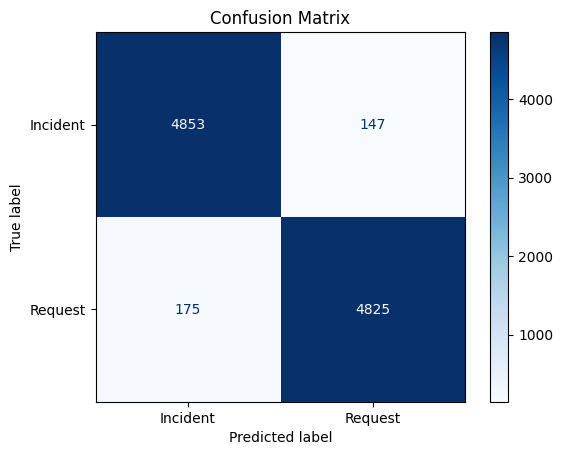

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# True labels and predicted labels
true_labels = output['ticket_type'].map(label2id)
pred_labels = output['predicted_ticket_type'].map(label2id)

# Create the confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1])

# Display the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=id2label.values())
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()